# Оценка зависимости от социальной сети VK

**Цель исследования:** по открытым данным оценить зависимость подростка-студента от социальной сети VK.

**Источник данных:** страница подростка в VK.

**Получение данных:** web-scraper загружает страницу каждые 15 минут и получает статус пользователя (online, offline, заходил х мин. назад и т.д.)

**Этика:** слежка за подростком неэтична и унизительна. Прибегать к ней возможно тогда и только тогда, когда родителей беспокоит здроровье или безопасность их ребёнка.

**Законодательство:** согласно статье 152.2 ГК РФ и статье 137 УК РФ сбор, хранение и распространение информации о частной жизни гражданина без его согласия запрещены и караются штрафом или лишением свободы. Уровень доступности страницы VK для публичного просмотра, установленный пользователем в настройках безопасности ("весь интернет", "только пользователи VK", "только друзья") можно расценивать не более как согласие пользователя на получение информации о нём (соответствующим кругом лиц), но ни в коем случае не как разрешение хранить или распространять её. 

*В данном исследовании используются анонимизированные данные случайного пользователя VK.*

**План исследования:**

**<a href="#preparation">1. Подготовка данных.</a>** Данные будут загружены из лог-файла скрапера, затем проверены и преобразованы в формат, удобный для исследования.

**<a href="#analysis">2. Анализ.</a>** Будет выполнен анализ данных с целью установить наличие, степень и динамику зависимости от социальной сети.

**<a href="#conclusion">3. Итоги.</a>** На основе анализа будут сделаны окончательные выводы о зависимости от социальной сети.


## Подготовка данных

### Загрузка

Подключим необходимые библиотеки загрузим данные из лог-файла скрапера:

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

time_unit = 15 # 15 минут - единица временной шкалы
day_name_ru = ('пн','вт','ср','чт','пт','|сб|','|вс|')
month_name_ru = ('---', 'январь', 'февраль', 'март', 'апрель', 'май', 
    'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь')

log = pd.read_csv('portfolio-vk-log.txt', sep='\t', header=None)
log.columns = ['datetime', 'is_online', 'min_left', 'comment']

Проверим, корректно ли загружены данные:

In [2]:
log.head(5)

,datetime,is_online,min_left,comment
0,03.08.2021 08:00,NaN,NaN,[m] заходил сегодня в 1:57
1,03.08.2021 08:15,NaN,NaN,[m] заходил сегодня в 1:57
2,03.08.2021 08:30,NaN,NaN,[m] заходил сегодня в 1:57
3,03.08.2021 08:45,NaN,NaN,[m] заходил сегодня в 1:57
4,03.08.2021 09:00,NaN,NaN,[m] заходил сегодня в 1:57


In [3]:
log.shape

(2480, 4)

Структура и значения в целом соответствют ожидаемым.

**Итог:** данные загружены успешно.

### Предобработка

Исправим типы данных в столбцах:

In [4]:
log['datetime'] = pd.to_datetime(log['datetime'], format='%d.%m.%Y %H:%M')
log['is_online'] = (log['is_online'] == '*')
log['min_left'] = log['min_left'].astype('Int64')
log.dtypes

datetime     datetime64[ns]
is_online              bool
min_left              Int64
comment              object
dtype: object

Проверим результат изменения типов данных:

In [5]:
log.tail(3)

,datetime,is_online,min_left,comment
2477,2021-09-11 19:15:00,False,<NA>,заходил час назад
2478,2021-09-11 19:30:00,True,0,NaN
2479,2021-09-11 19:45:00,False,15,NaN


Нормализуем текст комментариев и удалим записи, где скрапер сообщает о возникновении сбоев (и невозможности получить данные):

In [6]:
# Нормализуем текст комментариев
log['comment'] = log['comment'].str.strip().str.lower()
# Отбираем номера строк со сбоями загрузки
exception_rows_index = log[log['comment'].str.startswith('exception', na=False)].index
# Удалим строки со сбоями
log = log.drop(exception_rows_index)

Данные лог-файла скрапера приведены к нужным типам, из них исключены записи со сбоями.

**Итог:** данные лог-файла скрапера готовы к использованию.

### Реструктуризация

Заранее известно, что лог-файл скрапера содержит пропуски. Во-первых, в период с 2:00 до 8:00 скрапер не собирает данные. Во-вторых, скрапер временно может быть отключен или не запущен по ошибке. Соответственно в лог-файле не окажется записей за то время, когда скрапер не работал. Для анализа данных это неудобно. Реструктурируем данные так, чтобы на каждые 15 минут каждых суток было по одной записи в наборе данных:

In [7]:
min_date = log['datetime'].min().floor('D') # 22.01.2021 11:00 --> 22.01.2021 00:00 
max_date = log['datetime'].max().floor('D') # 30.01.2021 18:45 --> 30.01.2021 00:00
data = []
dt = min_date
while dt < max_date:
    data.append(dt)
    dt += datetime.timedelta(minutes=15)

# Создадим набор данных без пропусков времени и дат (одна строка на time_unit минут)
df = pd.DataFrame(data=data, columns=['datetime'])
# Добавим данные из лога (на те моменты времени, которые есть в логе)
df = df.merge(log, on='datetime', how='left')
# Пометим на будущее в отдельной колонке, какие данные есть, каких нет
df['is_na'] = df['is_online'].isna()

Проверим временную структуру данных:

In [8]:
df.shape[0], df['datetime'].min(), df['datetime'].max() 

(3748, Timestamp('2021-08-03 00:00:00'), Timestamp('2021-09-10 23:45:00'))

**Итог:** временная структура данных исправлена.

### Пропуски

Восстановим пропуски по данным, о том сколько минут назад был пользователь в сети:

In [9]:
x = (
    df[df['min_left'] > time_unit]
        .apply(lambda row: row['datetime'] - datetime.timedelta(minutes=row['min_left']), axis=1)
        .dt.ceil(freq=str(time_unit) + 'T')
        .unique()
)
rows_mask = df['datetime'].isin(x) & df['is_online'].isna()
df.loc[rows_mask, ['is_online', 'is_na']] = [True, False]
filled_by_minutes = df[rows_mask].index.to_list() # сохраняем для справки

Выделим компоненты даты и времени в отдельные стобцы для удобства дальнейшей обработки:

In [10]:
df['y'] = df['datetime'].dt.year
df['m'] = df['datetime'].dt.month
df['d'] = df['datetime'].dt.day
df['H'] = df['datetime'].dt.hour
df['M'] = df['datetime'].dt.minute

По фразе "заходил сегодня в чч:мм" восстановим пропуски в данных (где это возможно и нужно):

In [11]:
x = (
    df[df['comment'].notna() & df['comment'].str.contains('заходил сегодня')]
        .pivot_table(index=['y','m','d','comment'],  values='datetime', aggfunc='first')
        .reset_index()
        .apply(axis=1, func=lambda row: datetime.datetime(row['y'],row['m'],row['d'],
           int(row['comment'][-5:-3]), int(row['comment'][-2:])))
        .dt.ceil(freq=str(time_unit) + 'T')
        .unique()
)
rows_mask = df['datetime'].isin(x) & df['is_online'].isna()
df.loc[rows_mask, ['is_online', 'is_na']] = [True, False]
filled_by_comments = df[rows_mask].index.to_list() # сохраняем для справки

Заполним оставшиеся пропуски столбца is_online значениями False:

In [12]:
# Заполняем ночные пропуски, когда сканирование не работает
rows_mask = (df['H'] >= 2) & (df['H'] <= 7) & df['is_online'].isna()
filled_by_nights = df[rows_mask].index.to_list()
df.loc[rows_mask, ['is_online','is_na']] = [False, False]
# Заполняем остальные пропуски
df['is_online'] = df['is_online'].fillna(False).astype(bool)

Удалим ненужные столбцы:

In [13]:
df = df.drop(columns=['min_left','comment'])

Проверим наличие пропусков:

In [14]:
df.isna().sum()

datetime     0
is_online    0
is_na        0
y            0
m            0
d            0
H            0
M            0
dtype: int64

**Итог:** пропуски заполнены, пропусков нет.

### Набор данных с и без пропуска дней

Вероянты ситуации, когда в какие-то дни данных о посещении социальной сети нет вообще (скрапер целые сутки не работал) или записей слишком мало (скрапер работал не полные сутки или долгое время сеть была недоступна). Условимся, что если пропущено более 20% записей за сутки (около 5 часов), то такие сутки следует считать пропущенными (для большинства видов анализа). В дальнейшем удобно иметь два набора данных: с пропущенными днями и без. Создадим такие наборы:

In [15]:
df_all_days = df.copy()
maxnap = 0.20 # макс. число пропущенных записей, %
na_col = 'N/A'
gindex = ['y','m','d']
na = df.groupby(gindex)['is_na'].sum().reset_index().rename(columns={'is_na':na_col}) 
na[na_col] = na[na_col] / (24 * (60 / time_unit))
df = df.merge(na, on=gindex, how='left')
df = df[df[na_col] <= maxnap]
df = df.drop(columns=[na_col])
days_deleted = na[na[na_col] > maxnap]
df_filtred_by_na = df.copy()

In [16]:
print('Удалено дней c критичным пропуском данных (более {:.0%}) - {}.'.format(maxnap, days_deleted.shape[0]))
print()
print(f'df_all_days - набор со всеми днями независимо от числа пропусков, {df_all_days.shape[0]} строк')
print(f'df_filtred_by_na - набор без дней с большими пропусками, {df_filtred_by_na.shape[0]} строк')
print()

Удалено дней c критичным пропуском данных (более 20%) - 7.

df_all_days - набор со всеми днями независимо от числа пропусков, 3748 строк
df_filtred_by_na - набор без дней с большими пропусками, 3076 строк



**Итог:** наборы с пропуском дней и без созданы.

### Итоги

Подведём итоги подготовки данных:

In [17]:
df = df_filtred_by_na.copy()
begin = df['datetime'].min()
end = df['datetime'].max()
period_len_days = df.groupby(['y','m','d']).ngroups
fake_offline_n = df['is_na'].sum()
print(
    '---\n'
    'Период наблюдений: {} - {}\n'
    '---\n'
    'Дней с числом пропусков в пределах допустимого - {}.\n'
    'Записей в логе - {}, в наборе - {}.\n'
    'Заполнено пропусков (по min_left/по comment/ночь) - {}/{}/{}.\n'
    'Записей fake offline (для них возможно, что реальный статус online) - {} ({:.1%}).\n'
    '---'.format(
    begin, end, period_len_days,
    log.shape[0], df.shape[0], len(filled_by_minutes), 
    len(filled_by_comments), len(filled_by_nights), 
    fake_offline_n, fake_offline_n / df.shape[0])
)

---
Период наблюдений: 2021-08-03 00:00:00 - 2021-09-10 23:45:00
---
Дней с числом пропусков в пределах допустимого - 32.
Записей в логе - 2383, в наборе - 3076.
Заполнено пропусков (по min_left/по comment/ночь) - 9/10/928.
Записей fake offline (для них возможно, что реальный статус online) - 151 (4.9%).
---


Итак, данные загружены, проверены, исправлены и готовы к анализу.

<a id="analysis"></a>

## Анализ

### Распределение cуток

Создадим подпрограмму, которая расчитывает время непрерывного отсутствия в сети в условное время сна. Условное время сна - период с 00:00 до 08:00. Это время в идеале должно быть отдано сну. Регулярное присутствие в сети в этот период может свидетельствовать о недостатке сна или о нездоровом сне.

In [18]:
# Возвращает суммарное число непрерывного offline с 00:00 до 08:00
def get_sleep08(df):

    gindex = ['y','m','d']

    x = df[df['is_online'] & (df['H'] < 5)].pivot_table(
        index=gindex, values='datetime', aggfunc='max').reset_index()
    y = df[df['is_online'] & (df['H'] >= 5) & (df['H'] < 8)].pivot_table(
        index=gindex, values='datetime', aggfunc='min').reset_index()

    m = df[gindex].groupby(gindex).first().reset_index()
    if not x.empty:
        m = m.merge(x, on=gindex, how='left').rename(columns={'datetime':'tx'})
    else:
        m['tx'] = np.datetime64('NaT')
    m.loc[m['tx'].isna(),'tx'] = m[m['tx'].isna()].apply(axis=1, func=lambda row: 
        datetime.datetime(row['y'],row['m'],row['d'], 0,0,0))

    if not y.empty:
        m = m.merge(y, on=gindex, how='left').rename(columns={'datetime':'ty'})
    else:
        m['ty'] = np.datetime64('NaT')
    m.loc[m['ty'].isna(),'ty'] = m[m['ty'].isna()].apply(axis=1, func=lambda row: 
        datetime.datetime(row['y'],row['m'],row['d'], 8,0,0))
    
    m['ty - tx'] = (m['ty'] - m['tx']).dt.total_seconds()
    #print(m)    
    sum_ticks = int(m['ty - tx'].sum() / 60 / time_unit)
    ave_ticks = sum_ticks / m.shape[0]
    return (sum_ticks, ave_ticks)

Создадим подпрограмму, вычисляющую распределение времени суток на online, offline, условный-сон для заданного множества дней:

In [19]:
def get_pie_parts(df, start, end):
    data = df[(df['datetime'] > start) & (df['datetime'] <= end)]
    days = data.groupby(['y','m','d']).ngroups
    online_mean = data['is_online'].sum() / days * time_unit / 60
    sleep08, sleep08_mean = get_sleep08(data)
    sleep08_mean *= time_unit / 60
    offline924_mean = 24 - online_mean - sleep08_mean;
    online_mean = round(online_mean,1)
    sleep08_mean = round(sleep08_mean,1)
    offline924_mean = round(offline924_mean,1)
    return (online_mean, offline924_mean, sleep08_mean, days)

Получим среднее распределение времени в сутках для всего периода наблюдений, за последние 30 дней и за последние 7 дней:

In [20]:
df = df_filtred_by_na.copy()
begin = df['datetime'].min()
end = df['datetime'].max()
pie_all_days = get_pie_parts(df, begin, end)
pie_30_days = get_pie_parts(df, end - datetime.timedelta(days=30), end)
pie_7_days = get_pie_parts(df, end - datetime.timedelta(days=7), end)

pies_df = pd.DataFrame([pie_all_days, pie_30_days, pie_7_days],
    columns=['online','offline','sleep08', 'days rec'],
    index = ['all', '30', '7'])
pies_df.index.name = 'period (last n days)'
pies_df

,online,offline,sleep08,days rec
period (last n days),,,,
all,10.6,6.6,6.9,32
30,10.9,6.1,7.0,24
7,11.9,4.8,7.4,7


Отобразим таблицу в графическом виде:

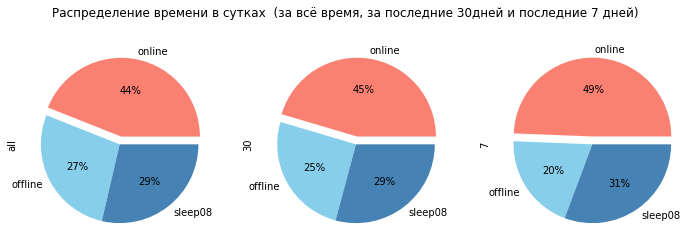

In [21]:
pies_df = pies_df.drop(columns=['days rec'])
pies_df.transpose().plot.pie(subplots=True, figsize=(12, 4), 
    legend=False, explode=[0.1,0,0], autopct='%1.0f%%',
    colors=['salmon', 'skyblue', 'steelblue'],
    title='Распределение времени в сутках  (за всё время, за последние 30дней и последние 7 дней)')
plt.show()

**Выводы:**
1. Почти половину суток составляют 15-тиминутные отрезки, когда подросток заходил в сеть не менее одного раза (особенно ярко это проявляется в последние семь дней).
2. Время условного сна (00:00-08:00) вместо 8 часов составляет в среднем 7 часов за период наблюдений и лишь с началом учебного года стало нормализоваться.
3. 15-тиминутные отрезки времени с 8:00 до 00:00, когда подросток не был сети ни разу, в сумме за сутки составляют лишь 5-6 часов - почти в два раза меньше, чем время online.

### Статистика по дням

Рассмотрим, как изменялось время присутствия в сети на протяжении дней:

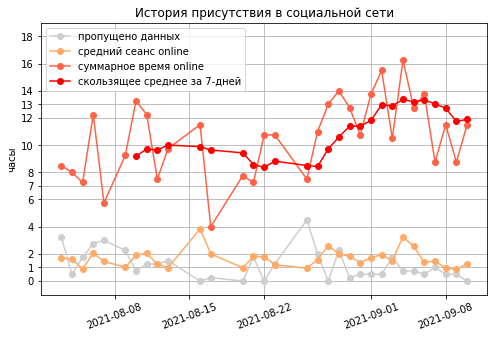

In [22]:
df = df_filtred_by_na.copy()
# отмечаем начало выхода в онлайн (чтобы потом получить число сессий за сутки)
df['online_start'] = (df['is_online'] - df['is_online'].shift()) > 0
gindex = ['y','m','d']
days = (
    df
    .pivot_table(index=gindex, values=['is_online','is_na', 'online_start'], aggfunc='sum')
    .reset_index()
    )
days['date'] = days.apply(axis=1, func=lambda row: datetime.date(row['y'],row['m'],row['d']))
days['online'] = days['is_online'] * time_unit / 60
days['offline'] = 24 - days['online']
days['is_na'] = days['is_na'] * time_unit / 60
days['rolling_mean'] = days['online'].rolling(7, min_periods=7).mean()
# средняя длительность сессии online (не прерывавшейся более чем на time_unit минут)
days['online_mean'] = days['online'] / days['online_start']

cardio = days[['date','is_na', 'online_mean', 'online','rolling_mean']].set_index('date')
ax = cardio.plot.line(figsize=(min(25,days.shape[0]*0.25),5), stacked=False, 
    rot=20, legend=True, color=['#CECECE', '#FFAA66', 'tomato', 'red'], 
    grid=True, style='o-')
ax.set_title('История присутствия в социальной сети')
ax.set_ylim(-1.0,19.0)
ax.set_yticks(ticks=[0,1,2,4,6,7,8,10,12,13,14,16,18])
ax.set_ylabel('часы')
ax.set_xlabel('')
ax.legend(['пропущено данных','средний сеанс online','суммарное время online', 
    'скользящее среднее за 7-дней'],
    loc='upper left')
plt.show()

**Выводы:**
1. Неделя после 1-го сентября характеризуется рекордным числом времени, проведённым в ВК. Вероятно добавилось время общения со знакомыми, вернувшимися после каникул, и/или время просмотра трафика, связанного с началом учебного года.
2. Длительность среднего сеанса пребывания в ВК (сеанса, прерывающегося не более чем на 15 минут) составляет обычно 1-2 часа.

### Почасовая статистика

Рассмотрим пребывание в ВК по часам:

In [23]:
def show_hours_matrix(days, start_date, end_date, hours_per_row):
    print()
    print(month_name_ru[start_date.month], '-', month_name_ru[end_date.month])
    df = days.copy()
    df = df[(df['datetime'].dt.date > start_date) & (df['datetime'].dt.date <= end_date) ]
    df['m-d'] = df.apply(axis=1, func=lambda row:'{:02d}.{:02d}'.format(row['m'],row['d'])) 
    df['wday'] = df.apply(axis=1, func=lambda row: day_name_ru[datetime.date(
        row['y'],row['m'],row['d']).weekday()])
    hours = df.pivot_table(index=['m-d','wday'], columns='H', values='is_online', aggfunc='sum')
    hours = hours.transpose()
    hours['H-H'] =  hours.apply(axis=1, func=lambda row: '{:02d}-{:02d}'.format(
        row.name // hours_per_row * hours_per_row, row.name // hours_per_row * hours_per_row + hours_per_row - 1))
    hours = hours.pivot_table(index='H-H', values=hours.columns[:-1], aggfunc='sum')
    hours.columns = pd.MultiIndex.from_tuples([(a[-2:],b) for a,b in hours.columns], names=['month:','week:'])
    hours.index.name=''
    hours = hours * time_unit / 60
    display(hours.style.background_gradient(cmap='OrRd', axis=None).format('{:.1f}')) 
    
n = 2   # число часов в строке
d = 16  # число дней в таблице

dx = df_all_days['datetime'].max()
end = datetime.date(dx.year, dx.month, dx.day)
start =  end - datetime.timedelta(days=d)

show_hours_matrix(df_all_days, start_date=start, end_date=end, hours_per_row=n)



август - сентябрь


month:,26,27,28,29,30,31,01,02,03,04,05,06,07,08,09,10
week:,чт,пт,|сб|,|вс|,пн,вт,ср,чт,пт,|сб|,|вс|,пн,вт,ср,чт,пт
,,,,,,,,,,,,,,,,
00-01,0.5,1.0,0.8,1.8,2.0,0.8,1.2,1.8,0.2,2.0,0.0,1.5,0.0,0.2,0.2,0.0
02-03,0.0,0.0,0.0,0.2,0.2,0.0,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08-09,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.8,0.2,1.0,0.5,1.0,0.0,0.8,0.2,1.0
10-11,1.2,1.8,1.5,1.5,1.5,2.0,1.5,1.2,1.8,2.0,2.0,1.8,2.0,1.0,2.0,1.5
12-13,2.0,2.0,2.0,2.0,1.8,1.2,2.0,2.0,0.2,2.0,1.5,1.8,1.8,1.2,0.8,1.2
14-15,1.0,1.8,1.5,1.8,2.0,0.0,1.8,1.8,1.5,2.0,1.8,1.2,0.2,2.0,0.2,1.5


**Выводы:**
1. У подростка наблюдается привычка регулярно засиживаться в сети за полночь, нередко позже часа ночи.
2. Первые учебные дни не привели к тому, что подросток на время занятий способен отвлечься от социальной сети. Периоды с редкими заходами в сеть появляются лишь на второй учебной неделе и то лишь во второй половине дня или вечером и не во все учебные дни.

### Статистика по дням недели

Посмотрим как распределено время присутствия в сети по дням недели:

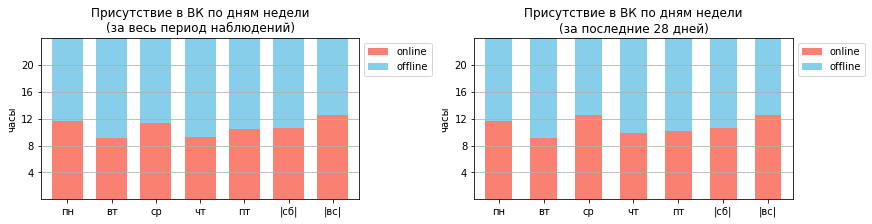

In [24]:
days = (
    df_filtred_by_na[['datetime', 'is_online']]
        .copy()
        .set_index('datetime')
        .resample('1D') # включит в days дни, которых нет в df_filtred_by_na
        .agg('sum')
    )
days = days.rename(columns={'is_online':'online'})
days = days.drop(days[days['online'] == 0].index) # исправляем побочный эффект .resample('1D')
days['weekday'] = days.index.weekday
days['online'] = days['online'] * 15 / 60
days['offline'] = 24 - days['online']
weekdays = days.pivot_table(index='weekday', values=['online','offline'], aggfunc='mean')
weekdays = weekdays[['online','offline']]
weekdays['day_name'] = weekdays.apply(axis=1, func=lambda row: day_name_ru[row.name])

days28 = days.tail(28)
weekdays28 = days28.pivot_table(index='weekday', values=['online','offline'], aggfunc='mean')
weekdays28 = weekdays28[['online','offline']]
weekdays28['day_name'] = weekdays.apply(axis=1, func=lambda row: day_name_ru[row.name])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3), constrained_layout=True)

ax = weekdays28.plot(ax=axes[1], width=0.6,
    kind='bar', stacked=True, x='day_name', xlabel='', rot=0, 
    legend=True, color=['salmon','skyblue'])
ax.set_title('Присутствие в ВК по дням недели\n(за последние 28 дней)')
ax.grid(axis='y')
ax.set_ylim(0,24)
ax.set_yticks(ticks=[4,8,12,16,20])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel('часы')

ax = weekdays.plot(ax=axes[0], width=0.7,
    kind='bar', stacked=True, x='day_name', xlabel='', rot=0, 
    legend=True, color=['salmon','skyblue'])
ax.set_title('Присутствие в ВК по дням недели\n(за весь период наблюдений)')
ax.grid(axis='y')
ax.set_ylim(0,24)
ax.set_yticks(ticks=[4,8,12,16,20])
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel('часы')

plt.show()

**Выводы.**
Большого различия между днями недели не наблюдается. Нельзя сказать, что по поведению подростка можно отличить, например, будние дни от выходных. Присутствие в ВК во все дни недели примерно одинаково. Распределение по дням недели не позволяет сделать никаких определённых выводов.

<a id="conclusion"></a>

## Итоги исследования

Данные показывают, что у подростка присутствует сильная зависимость от социальной сети ВК. Суммарно за сутки он проводит в ней (не отвлекаясь более, чем на 15 минут) по 10-12 часов, регулярно ложится спать глубоко заполночь и постоянно отвлекается от занятий или вовсе не посещает их. По реакции на начало учебного года (аномально длительное время присутствия в сети в течение первой недели) есть основания полагать, что подросток живому общению предпочитает жизнь в сети.